# Tutorial 3: Deep learning classifiers for bifurcation prediction

This tutorial assumes that you are familiar with the tools demonstrated in Tutorial 1.

By the end of this tutorial you should know how to:
- Import a TensorFlow classifier and obtain its predictions on a section of time series data
- Compute predictions made from an ensemble of classifiers


We will be using the classifiers trained in the study by [Bury et al. (2021)](https://royalsocietypublishing.org/doi/full/10.1098/rsif.2020.0482).


Notebook run time : 2 min 18 s on Macbook Air (M1, 2020)

## Motivation

Deep learning classifiers were recently shown to be effective at predicting upcoming bifurcations and their type [(Bury et al. (2020)](https://www.pnas.org/doi/10.1073/pnas.2106140118). *ewstools* has the functionality to apply these types of classifier to time series data. For methods on how these classifiers are trained, please see the paper.

## Import libraries

In [33]:
# Start timer to record execution time of notebook
import time
start_time = time.time()

In [54]:
import numpy as np
np.random.seed(0) # Set seed for reproducibility

import pandas as pd
import matplotlib.pyplot as plt
import os

from IPython.display import Image

import ewstools
from ewstools.models import simulate_may, simulate_rosen_mac

In [35]:
# Tensorflow imports
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # comment out to see TensorFlow warnings 
from tensorflow.keras.models import load_model

## Simulate model data

We will use May's harvesting model and the Rosenzweig-MacArthur consumer-resource model to simulate trajectories going through a fold, Hopf and transcritical bifurcation. Functions to simulate these models exists in *ewstools* as [`simulate_may()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.models.simulate_may) and [`simulate_rosen_mac()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.models.simulate_rosen_mac).

In [4]:
series_may = simulate_may(tmax=500, dt=0.01, h=[0.15,0.28]).iloc[::100]
series_rm_hopf = simulate_rosen_mac(tmax=500, dt=0.01, a=[12,16]).iloc[::100]
series_rm_tc = simulate_rosen_mac(tmax=500, dt=0.01, a=[2,6]).iloc[::100]

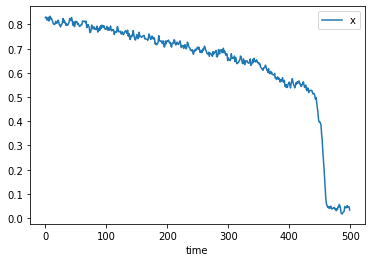

In [5]:
series_may.plot();

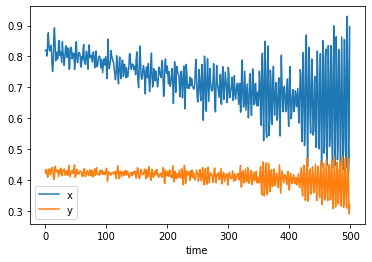

In [6]:
series_rm_hopf.plot();

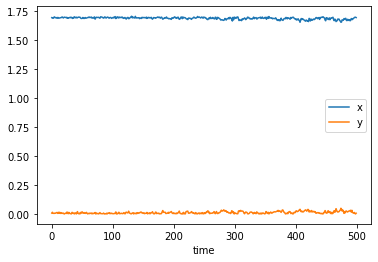

In [7]:
series_rm_tc.plot();

## Set up TimeSeries object and detrend

As per usual, we now define a [`TimeSeries`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries) object for each time series we wish to analyse. Note this only takes in a 1D time series. We will consider the resource variable (x) in the Rosenzweig-Macarthur model. We will just eyeball transition times for this tutorial. A more rigorous approach could be to use change-point algorithms, or use the time that the bifurcation is crossed in the model.

In [37]:
ts_may = ewstools.TimeSeries(series_may['x'], transition=420)
ts_rm_hopf = ewstools.TimeSeries(series_rm_hopf['x'], transition=420)
ts_rm_tc = ewstools.TimeSeries(series_rm_tc['x'], transition=420)

Now let's detrend the data using the method [`detrend()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.detrend). We will use a Lowess filter with a span of 0.2.

In [38]:
ts_may.detrend(method='Lowess', span=0.2)
ts_rm_hopf.detrend(method='Lowess', span=0.2)
ts_rm_tc.detrend(method='Lowess', span=0.2)

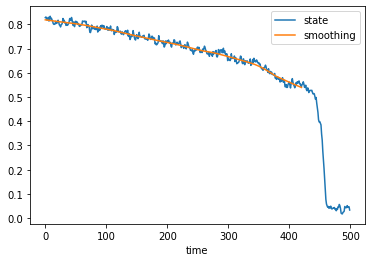

In [39]:
ts_may.state[['state','smoothing']].plot();

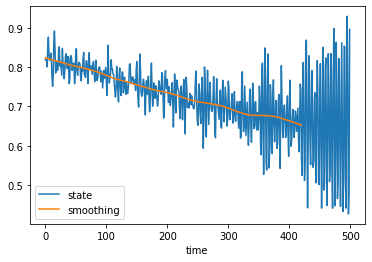

In [40]:
ts_rm_hopf.state[['state','smoothing']].plot();

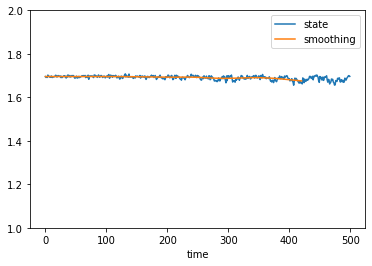

In [41]:
ts_rm_tc.state[['state','smoothing']].plot(ylim=[1,2]);

## Compute predictions of a DL classifier

The method [`apply_classifier()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.apply_classifier) applies a deep learning classifier (a TensorFlow [Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)) to a segment of the time series data, specified using `tmin` and `tmax`. The prediction (a vector of probabilites for each class) is then saved into the attribute `dl_preds`, which is a pandas DataFrame.

Let's see this in action. We will import a classifier that was trained  trained in the study [Bury et al. (PNAS, 2022)](https://www.pnas.org/doi/10.1073/pnas.2106140118). In this study, the classifier was trained to predict the following classes:

| Key | Trajectory |
| :- | :- |
| 0 | fold bifurcation |
| 1 | Hopf bifurcation | 
| 2 | transcritical bifurcation |
| 3 | null |

In [24]:
classifier_path = '../saved_classifiers/bury_pnas_21/len500/best_model_1_1_len500.pkl'
classifier = load_model(classifier_path)

Let's apply the classifier to the fold trajectory using data from time 0 to time 400.

In [46]:
ts_may.apply_classifier(classifier, tmin=0, tmax=400)

1/1 [==============================] - 0s 30ms/step


We can view the predictions inside the attribute `dl_preds`.

In [48]:
ts_may.dl_preds

,0,1,2,3,time,classifier
0,0.751295,0.030536,0.21511,0.003059,400,c1


and see that the weight assigned to the fold bifurcation is the largest. Therefore, using data from t=0 to t=400, the classifier correctly interprets this as an approaching fold bifurcation. We would like to know the predictions made by the DL classifier as the time series progresses. Therefore, there is another method [`apply_classifier_inc()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.apply_classifier_inc) that computes the prediction of the classifier as the length of the time series becomes incrementally longer. It always sees the beginning of the time series, and the end of the time series becomes progressively closer to the bifurcation.

In [50]:
ts_may.clear_dl_preds() # Clear data in dl_preds
ts_may.apply_classifier_inc(classifier, inc=10, verbose=0)

Now `dl_preds` should contain many predictions each made at a different time

In [51]:
ts_may.dl_preds.head()

,0,1,2,3,time,classifier
0,0.207065,0.339513,0.247485,0.205937,0.0,c1
1,0.228072,0.376060,0.219008,0.176861,10.0,c1
2,0.250696,0.294206,0.267425,0.187674,20.0,c1
3,0.225095,0.144681,0.282058,0.348166,30.0,c1
4,0.212830,0.046121,0.296307,0.444743,40.0,c1


which we can plot using [`make_plotly()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.make_plotly)

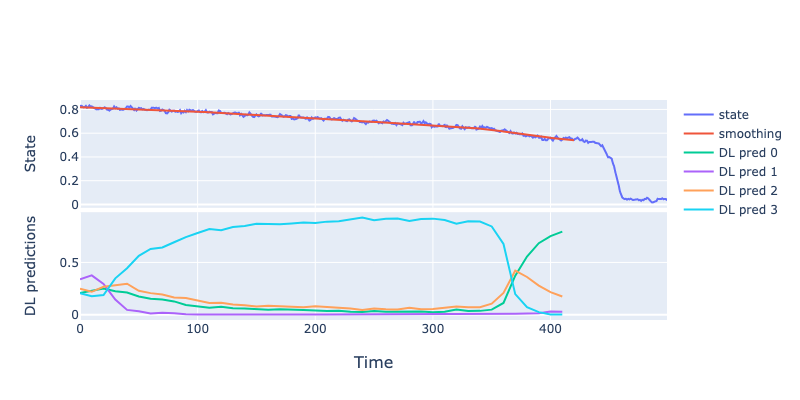

In [57]:
fig = ts_may.make_plotly()
Image(fig.to_image()) # use fig.show() to show interactive figure

We see that around t=370, the classifier changes its mind from the system being in a 'null' trajectory to being in a 'fold' trajectory. Let's repeat the analysis for the other two bifurcation trajectories.

In [60]:
ts_rm_hopf.clear_dl_preds()
ts_rm_tc.clear_dl_preds()

In [61]:
ts_rm_hopf.apply_classifier_inc(classifier, inc=10, verbose=0)
ts_rm_tc.apply_classifier_inc(classifier, inc=10, verbose=0)

In [62]:
ts_rm_hopf.make_plotly()

In [63]:
ts_rm_tc.make_plotly()

We can see that the DL classifier is able to correctly identify these bifurcations before they occur.

## Ensemble modelling

The previous predictions were obtained from a single classifier. To improve overall performance, we can use ensemble modelling, which involves taking the average of predictions from multiple classifiers. Let's import all 20 classifiers that were trained in the PNAS study by (those that were trained on time series with 500 data points). They are saved in the *ewstools* Github repository. We will just apply these classifiers to the fold trajectory as it takes a couple of minutes to run.

In [65]:
# Clear previous DL predictions
ts_may.clear_dl_preds()
ts_rm_hopf.clear_dl_preds()
ts_rm_tc.clear_dl_preds()

In [66]:
# Get classifier names
root_path = '../saved_classifiers/bury_pnas_21/len500/'
classifier_names = [name for name in os.listdir(root_path) if name[-4:]=='.pkl']

In [67]:
# Takes ~ 2 minutes to run on Macbook Air (M1, 2020)
# Loop through each classifier
for classifier_name in classifier_names:
    # Import classifier
    classifier = load_model(root_path + classifier_name)
    # Get DL predictions - note we can provide a classifier name for reference
    ts_may.apply_classifier_inc(classifier, inc=10, verbose=0, name=classifier_name)
    print('Predictions complete for classifier {}'.format(classifier_name))

Predictions complete for classifier best_model_5_1_len500.pkl
Predictions complete for classifier best_model_2_1_len500.pkl
Predictions complete for classifier best_model_7_2_len500.pkl
Predictions complete for classifier best_model_6_2_len500.pkl
Predictions complete for classifier best_model_1_2_len500.pkl
Predictions complete for classifier best_model_3_1_len500.pkl
Predictions complete for classifier best_model_4_1_len500.pkl
Predictions complete for classifier best_model_9_1_len500.pkl
Predictions complete for classifier best_model_8_1_len500.pkl
Predictions complete for classifier best_model_10_2_len500.pkl
Predictions complete for classifier best_model_10_1_len500.pkl
Predictions complete for classifier best_model_8_2_len500.pkl
Predictions complete for classifier best_model_9_2_len500.pkl
Predictions complete for classifier best_model_3_2_len500.pkl
Predictions complete for classifier best_model_4_2_len500.pkl
Predictions complete for classifier best_model_6_1_len500.pkl
Predic

Now *dl_preds* should contain predictions made from multiple classifiers:

In [69]:
ts_may.dl_preds['classifier'].unique()

array(['best_model_5_1_len500.pkl', 'best_model_2_1_len500.pkl',
       'best_model_7_2_len500.pkl', 'best_model_6_2_len500.pkl',
       'best_model_1_2_len500.pkl', 'best_model_3_1_len500.pkl',
       'best_model_4_1_len500.pkl', 'best_model_9_1_len500.pkl',
       'best_model_8_1_len500.pkl', 'best_model_10_2_len500.pkl',
       'best_model_10_1_len500.pkl', 'best_model_8_2_len500.pkl',
       'best_model_9_2_len500.pkl', 'best_model_3_2_len500.pkl',
       'best_model_4_2_len500.pkl', 'best_model_6_1_len500.pkl',
       'best_model_1_1_len500.pkl', 'best_model_7_1_len500.pkl',
       'best_model_5_2_len500.pkl', 'best_model_2_2_len500.pkl'],
      dtype=object)

When predictions from multiple classifiers exists [`make_plotly()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.make_plotly) takes the average prediction before plotting. We can now see predictions from the 'ensemble model'. It is wise to use ensemble modelling, as individual classifiers can be fragile.

In [71]:
ts_may.dl_preds.head()

,0,1,2,3,time,classifier
0,0.169997,0.401140,0.265134,0.163728,0.0,best_model_5_1_len500.pkl
1,0.075660,0.656925,0.184020,0.083396,10.0,best_model_5_1_len500.pkl
2,0.105839,0.611917,0.242228,0.040017,20.0,best_model_5_1_len500.pkl
3,0.184715,0.332230,0.456766,0.026289,30.0,best_model_5_1_len500.pkl
4,0.248066,0.135157,0.591709,0.025068,40.0,best_model_5_1_len500.pkl


In [70]:
ts_may.make_plotly()

In [ ]:
df_dl_preds_av = ts.dl_preds.groupby(['time']).mean()
df_dl_preds_av.head()

That's it! Feel free to copy and play around with this notebook for your own data.

In [ ]:
# Stop timer
end_time = time.time()
print('Notebook took {:.1f}s to run'.format(end_time-start_time))